In [26]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score
from functools import partial



<h3>Prepare Datasets</h3>

In [2]:
train_dataset = pd.read_csv('Datasets/train_dataset.csv')
test_dataset = pd.read_csv('Datasets/test_dataset.csv')

train_pca_dataset = pd.read_csv('Datasets/PCA_train_data.csv')
test_pca_dataset = pd.read_csv('Datasets/PCA_test_data.csv')

train_tree_dataset = pd.read_csv('Datasets/Tree_train_data.csv')
test_tree_dataset = pd.read_csv('Datasets/Tree_test_data.csv')


X_train = train_dataset.drop(['is_attack' , 'attack_category' , 'attack'], axis=1)
y_train = train_dataset['attack_category']

X_test = test_dataset.drop(['is_attack' , 'attack_category' , 'attack'], axis=1)
y_test = test_dataset['attack_category']

from tensorflow.keras.utils import to_categorical

# Convert integer labels to one-hot encoded format
y_train_one_hot = to_categorical(y_train, num_classes=5)
y_test_one_hot = to_categorical(y_test, num_classes=5)

X_pca_train = train_pca_dataset.drop(['is_attack' , 'attack_category' , 'attack'], axis=1)
y_pca_train = train_pca_dataset['attack_category']

X_pca_test = test_pca_dataset.drop(['is_attack' , 'attack_category' , 'attack'], axis=1)
y_pca_test = test_pca_dataset['attack_category']

X_tree_train = train_tree_dataset.drop(['is_attack' , 'attack_category' , 'attack'], axis=1)
y_tree_train = train_tree_dataset['attack_category']

X_tree_test = test_tree_dataset.drop(['is_attack' , 'attack_category' , 'attack'], axis=1)
y_tree_test = test_tree_dataset['attack_category']

In [3]:
def train_model(model, X, y):
    skf = StratifiedKFold(n_splits=5)

    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for train_index, test_index in skf.split(X, y):
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_test, y_test = X.iloc[test_index], y.iloc[test_index]

        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, pred)
        precision = precision_score(y_test, pred, average='weighted')
        recall = recall_score(y_test, pred, average='weighted') 
        f1 = f1_score(y_test, pred, average='weighted') 

        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

    # print('{0} Accuracy: {1: .5f} Precision: {2: .5f} Recall: {3: .5f} F1_Score: {4: .5f}'.format(
    #     model.__class__.__name__, 
    #     np.mean(accuracy_scores),
    #     np.mean(precision_scores),
    #     np.mean(recall_scores),
    #     np.mean(f1_scores)))
    
    return -np.mean(f1_scores)

In [4]:
def evaluate(model, X_train, y_train, X_test, y_test):
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print("Model: ", model.__class__.__name__)
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1 Score: ", f1)
    print("####################################")
    
    # report = classification_report(y_test, y_pred)
    # print("Classification Report:\n", report)
    
    return -f1

<h3> Model for Neural Network without PCA or Tree </h3>

In [5]:
num_classes = 5
tf.random.set_seed(42)
nn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu', input_shape=(X_train.shape[1:]), 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.42),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.42),
    tf.keras.layers.Dense(units=512, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.42),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.42),
    tf.keras.layers.Dense(units=num_classes, activation='softmax'),  # Change to softmax for multiclass
])


In [6]:
def f1_metric(y_true, y_pred):
    y_pred_labels = tf.argmax(y_pred, axis=1)
    f1_partial = partial(f1_score, average='macro')
    f1 = tf.py_function(f1_partial, (y_true, y_pred_labels), tf.float32)
    return f1

# Compile the model with Adam optimizer and F1 metric
nn_model.compile(optimizer=Adam(learning_rate=0.002),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=[f1_metric])


In [7]:
nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2944      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               66048     
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               6

In [8]:
nn_history = nn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, verbose=1)

Epoch 1/10
3937/3937 [==============================] - 74s 18ms/step - loss: 0.1763 - f1_metric: 0.8920 - val_loss: 1.4352 - val_f1_metric: 0.5857
Epoch 2/10
3937/3937 [==============================] - 62s 16ms/step - loss: 0.1154 - f1_metric: 0.9136 - val_loss: 1.4923 - val_f1_metric: 0.5813
Epoch 3/10
3937/3937 [==============================] - 55s 14ms/step - loss: 0.1109 - f1_metric: 0.9184 - val_loss: 2.0599 - val_f1_metric: 0.5730
Epoch 4/10
3937/3937 [==============================] - 65s 16ms/step - loss: 0.1109 - f1_metric: 0.9166 - val_loss: 1.6647 - val_f1_metric: 0.6201
Epoch 5/10
3937/3937 [==============================] - 64s 16ms/step - loss: 0.1105 - f1_metric: 0.9195 - val_loss: 1.2842 - val_f1_metric: 0.6253
Epoch 6/10
3937/3937 [==============================] - 65s 16ms/step - loss: 0.1116 - f1_metric: 0.9187 - val_loss: 1.7899 - val_f1_metric: 0.5629
Epoch 7/10
3937/3937 [==============================] - 59s 15ms/step - loss: 0.1091 - f1_metric: 0.9215 - val_l

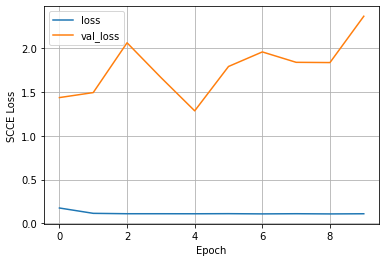

In [9]:
plt.plot(nn_history.history['loss'], label='loss')
plt.plot(nn_history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('SCCE Loss')
plt.legend()
plt.grid(True)

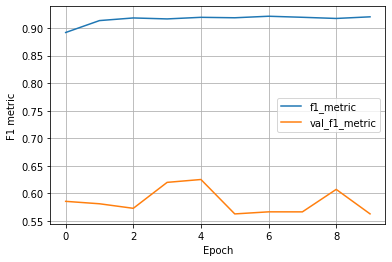

In [10]:
plt.plot(nn_history.history['f1_metric'], label='f1_metric')
plt.plot(nn_history.history['val_f1_metric'], label='val_f1_metric')
plt.xlabel('Epoch')
plt.ylabel('F1 metric')
plt.legend()
plt.grid(True)

In [31]:
y_pred_probs = nn_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=-1)


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the metrics
print("Accuracy for default dataset:", accuracy)
print("Precision for default dataset:", precision)
print("Recall for default dataset:", recall)
print("F1 Score for default dataset:", f1)

705/705 [==============================] - 2s 3ms/step
Accuracy for default dataset: 0.752971965933286
Precision for default dataset: 0.6871058416976646
Recall for default dataset: 0.752971965933286
F1 Score for default dataset: 0.7025396740939114


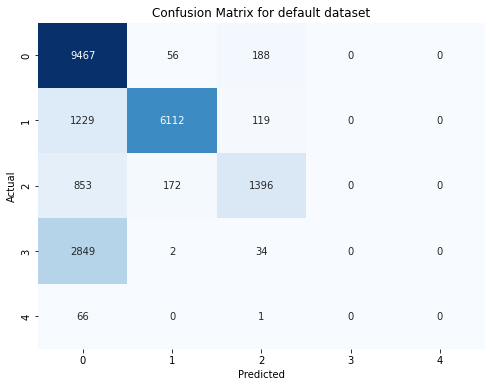

In [32]:
cm = confusion_matrix(y_test, y_pred)

# Displaying the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.title("Confusion Matrix for default dataset")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

<h3> Neural networks with PCA </h3>

In [15]:
tf.random.set_seed(42)
nn_model_pca = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu', input_shape=(X_pca_train.shape[1:]), 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.42),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.42),
    tf.keras.layers.Dense(units=512, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.42),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.42),
    tf.keras.layers.Dense(units=num_classes, activation='softmax'),  # Change to softmax for multiclass
])

In [16]:
# Compile the model with Adam optimizer and F1 metric
nn_model_pca.compile(optimizer=Adam(learning_rate=0.002),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=[f1_metric])


In [17]:
nn_history_pca = nn_model_pca.fit(X_pca_train, y_pca_train, validation_data=(X_pca_test, y_pca_test), epochs=10, verbose=1)

Epoch 1/10
3937/3937 [==============================] - 63s 15ms/step - loss: 0.1981 - f1_metric: 0.8834 - val_loss: 1.3942 - val_f1_metric: 0.5646
Epoch 2/10
3937/3937 [==============================] - 57s 14ms/step - loss: 0.1412 - f1_metric: 0.8970 - val_loss: 1.3360 - val_f1_metric: 0.5816
Epoch 3/10
3937/3937 [==============================] - 55s 14ms/step - loss: 0.1381 - f1_metric: 0.9039 - val_loss: 2.0195 - val_f1_metric: 0.5875
Epoch 4/10
3937/3937 [==============================] - 55s 14ms/step - loss: 0.1342 - f1_metric: 0.9032 - val_loss: 1.6139 - val_f1_metric: 0.5796
Epoch 5/10
3937/3937 [==============================] - 58s 15ms/step - loss: 0.1319 - f1_metric: 0.9085 - val_loss: 1.3507 - val_f1_metric: 0.6379
Epoch 6/10
3937/3937 [==============================] - 63s 16ms/step - loss: 0.1316 - f1_metric: 0.9062 - val_loss: 1.5531 - val_f1_metric: 0.5857
Epoch 7/10
3937/3937 [==============================] - 55s 14ms/step - loss: 0.1319 - f1_metric: 0.9073 - val_l

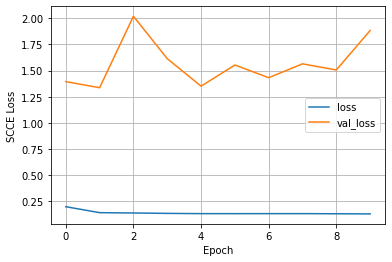

In [18]:
plt.plot(nn_history_pca.history['loss'], label='loss')
plt.plot(nn_history_pca.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('SCCE Loss')
plt.legend()
plt.grid(True)

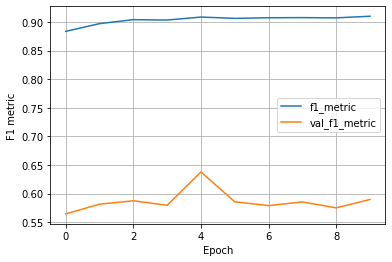

In [19]:
plt.plot(nn_history_pca.history['f1_metric'], label='f1_metric')
plt.plot(nn_history_pca.history['val_f1_metric'], label='val_f1_metric')
plt.xlabel('Epoch')
plt.ylabel('F1 metric')
plt.legend()
plt.grid(True)

In [20]:
y_pred_probs_pca = nn_model_pca.predict(X_pca_test)
y_pred_pca = np.argmax(y_pred_probs_pca, axis=-1)


accuracy_pca = accuracy_score(y_pca_test, y_pred_pca)
precision_pca = precision_score(y_pca_test, y_pred_pca, average='weighted')
recall_pca = recall_score(y_pca_test, y_pred_pca, average='weighted')
f1_pca = f1_score(y_pca_test, y_pred_pca, average='weighted')

# Print the metrics
print("Accuracy for PCA:", accuracy_pca)
print("Precision for PCA:", precision_pca)
print("Recall for PCA:", recall_pca)
print("F1 Score for PCA:", f1_pca)

705/705 [==============================] - 3s 4ms/step
Accuracy for PCA: 0.7682753726046841
Precision for PCA: 0.7703920336467498
Recall for PCA: 0.7682753726046841
F1 Score for PCA: 0.7179178428619197


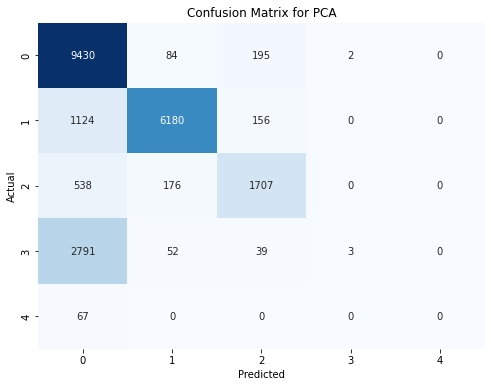

In [28]:
cm_pca = confusion_matrix(y_pca_test, y_pred_pca)

# Displaying the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_pca, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=np.unique(y_pca_test),
            yticklabels=np.unique(y_pca_test))
plt.title("Confusion Matrix for PCA")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

<h3> Neural networks for tree </h3>

In [21]:
nn_model_tree = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu', input_shape=(X_tree_train.shape[1:]), 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.42),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.42),
    tf.keras.layers.Dense(units=512, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.42),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.42),
    tf.keras.layers.Dense(units=num_classes, activation='softmax'),  # Change to softmax for multiclass
])

In [22]:


# Compile the model with Adam optimizer and F1 metric
nn_model_tree.compile(optimizer=Adam(learning_rate=0.002),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=[f1_metric])



In [23]:
nn_history_tree = nn_model_tree.fit(X_tree_train, y_tree_train, validation_data=(X_tree_test, y_tree_test), epochs=10, verbose=1)

Epoch 1/10
3937/3937 [==============================] - 75s 18ms/step - loss: 0.1763 - f1_metric: 0.8915 - val_loss: 1.4026 - val_f1_metric: 0.5863
Epoch 2/10
3937/3937 [==============================] - 72s 18ms/step - loss: 0.1167 - f1_metric: 0.9112 - val_loss: 1.5274 - val_f1_metric: 0.5842
Epoch 3/10
3937/3937 [==============================] - 72s 18ms/step - loss: 0.1150 - f1_metric: 0.9204 - val_loss: 1.9725 - val_f1_metric: 0.5633
Epoch 4/10
3937/3937 [==============================] - 72s 18ms/step - loss: 0.1106 - f1_metric: 0.9193 - val_loss: 1.7263 - val_f1_metric: 0.5870
Epoch 5/10
3937/3937 [==============================] - 71s 18ms/step - loss: 0.1077 - f1_metric: 0.9269 - val_loss: 1.3491 - val_f1_metric: 0.5915
Epoch 6/10
3937/3937 [==============================] - 71s 18ms/step - loss: 0.1074 - f1_metric: 0.9223 - val_loss: 1.7873 - val_f1_metric: 0.5848
Epoch 7/10
3937/3937 [==============================] - 67s 17ms/step - loss: 0.1067 - f1_metric: 0.9228 - val_l

In [24]:
y_pred_probs_tree = nn_model_tree.predict(X_tree_test)
y_pred_tree = np.argmax(y_pred_probs_tree, axis=-1)


accuracy_tree = accuracy_score(y_tree_test, y_pred_tree)
precision_tree = precision_score(y_tree_test, y_pred_tree, average='weighted')
recall_tree = recall_score(y_tree_test, y_pred_tree, average='weighted')
f1_tree= f1_score(y_tree_test, y_pred_tree, average='weighted')

# Print the metrics
print("Accuracy for tree:", accuracy_tree)
print("Precision for tree:", precision_tree)
print("Recall for tree:", recall_tree)
print("F1 Score for tree:", f1_tree)

705/705 [==============================] - 3s 3ms/step
Accuracy for tree: 0.7574964513839603
Precision for tree: 0.8036015029020531
Recall for tree: 0.7574964513839603
F1 Score for tree: 0.7157200124883416


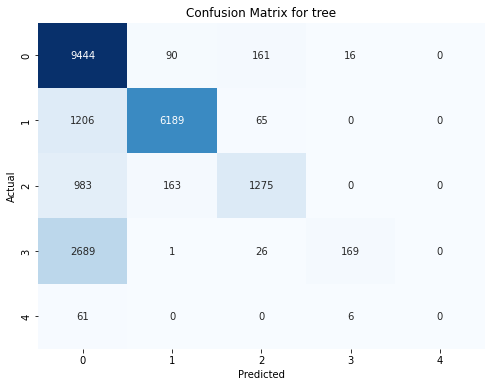

In [30]:
cm_tree = confusion_matrix(y_tree_test, y_pred_tree)

# Displaying the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tree, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=np.unique(y_tree_test),
            yticklabels=np.unique(y_tree_test))
plt.title("Confusion Matrix for tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()